In [1]:
import yaml
import sys
import os

sys.path.append(os.path.dirname(os.getcwd()))
from config import *

results_path = '../results/stats'
trace_mpki_file = '../traces/mpki.csv'

singlecore_trace_list = []
with open(trace_mpki_file, 'r') as f:
  for line in f:
    line = line.strip()
    trace, mpki = line.split(',')
    singlecore_trace_list.append(trace)

data = {}
for device in device_list:
  for org in org_list:
    for row_policy in row_policy_list:
      for timing in timing_list[device]:
        for trace in singlecore_trace_list:
          run_file = f'{device}_{org}_{timing}_{row_policy}_{trace}'
          with open(f'{results_path}/{run_file}.yaml', 'r') as f:
            data[run_file] = yaml.load(f, Loader=yaml.FullLoader)

In [4]:
normalized_to = 'DDR4'
sort_by = 'URAM4'

device_list     = ['DDR4', 'DDR5', 'URAM4', 'URAM5', 'FURAM4', 'FURAM5']
org_list        = ['16Gb_x8']
row_policy_list = ['OpenRowPolicy', 'ClosedRowPolicy']
trace_list      = list(singlecore_trace_list)[:len(singlecore_trace_list)//2]
timing_list     = {
  'DDR4'  : '3200AA',
  'DDR5'  : '3200AN',
  'URAM4' : '3200AA',
  'URAM5' : '3200AN',
  'FURAM4': '3200AA',
  'FURAM5': '3200AN'
}

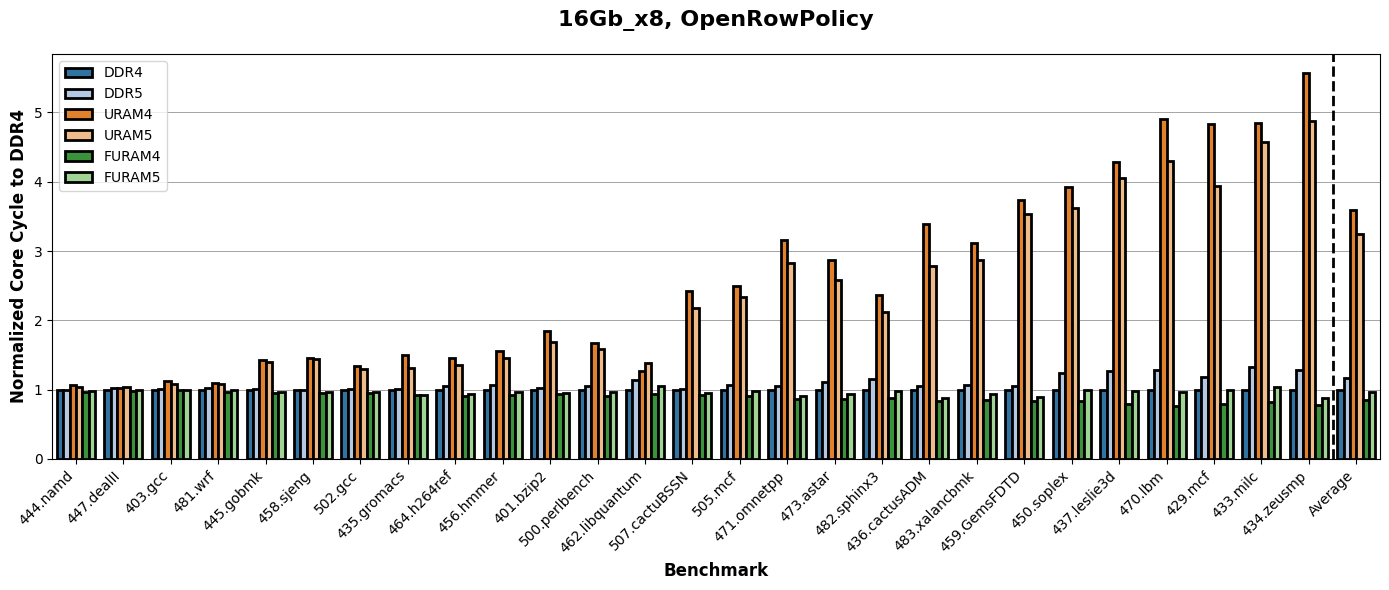

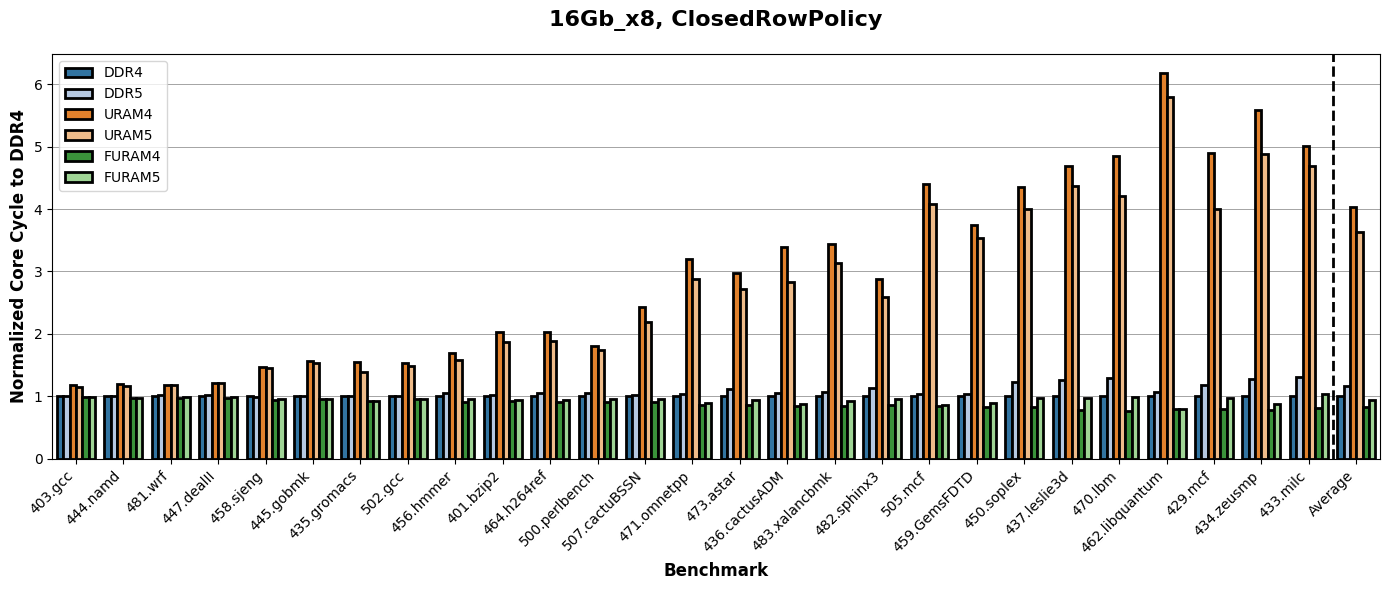

In [5]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def get_stats(device, org, timing_list, row_policy, trace):
  return data[f'{device}_{org}_{timing_list[device]}_{row_policy}_{trace}']['Frontend']['cycles_recorded_core_0']

def create_dataframe(sorted_data):
  benchmarks = []
  core_cycles = []
  devices = []

  for item in sorted_data:
    trace = item[0]
    device_data = item[1:]
    benchmarks.extend([trace] * len(device_list))
    core_cycles.extend([data / device_data[device_list.index(normalized_to)] for data in device_data])
    devices.extend(device_list)

  return pd.DataFrame({
      'Benchmark': benchmarks,
      f'Normalized Core Cycle to {normalized_to}': core_cycles,
      'Device': devices
  })

def add_average_to_dataframe(df, core_cycle_list):
    avg_list = [np.mean(core_cycle_list[device] / np.mean(core_cycle_list[normalized_to])) for device in device_list]
    avg_df = pd.DataFrame({
        'Benchmark': ['Average'] * len(device_list),
        f'Normalized Core Cycle to {normalized_to}': avg_list,
        'Device': device_list
    })
    return pd.concat([df, avg_df], ignore_index=True)

def plot_data(df, org, row_policy):
    plt.figure(figsize=(14, 6))
    barplot = sns.barplot(x='Benchmark', y=f'Normalized Core Cycle to {normalized_to}', hue='Device', 
                          edgecolor='black', linewidth=2, 
                          palette=sns.color_palette('tab20', n_colors=len(device_list)),
                          zorder=2, data=df)

    barplot.legend(loc='upper left')
    barplot.set_xlabel('Benchmark', fontsize=12, fontweight='bold')
    barplot.set_ylabel(f'Normalized Core Cycle to {normalized_to}', fontsize=12, fontweight='bold')
    barplot.grid(True, which='major', axis='y', linestyle='-', linewidth=0.5, color='gray', zorder=0)

    plt.xticks(rotation=45, ha='right')
    plt.title(f'{org}, {row_policy}', fontsize=16, fontweight='bold', pad=20)
    plt.axvline(x=len(trace_list) - 0.5, color='black', linestyle='--', linewidth=2)

    plt.tight_layout()
    plt.show()

for org in org_list:
  for row_policy in row_policy_list:
    core_cycle_list = {device: [] for device in device_list}
    
    for device in device_list:
      for trace in trace_list:
        core_cycle_list[device].append(get_stats(device, org, timing_list, row_policy, trace))

    sorted_data = sorted(zip(trace_list, *[core_cycle_list[device] for device in device_list]), 
                          key=lambda x: x[1 + device_list.index(sort_by)])

    df = create_dataframe(sorted_data)
    df = add_average_to_dataframe(df, core_cycle_list)

    plot_data(df, org, row_policy)